In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import os

plt.rcParams['figure.figsize'] = [15, 15]

In [11]:
# Converte imagem para grayscale e RGB
def read_image(path):
    img = cv2.imread(path)
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_gray, img_rgb

folder = 'images'
left_gray, left_rgb = read_image(os.path.join(folder, "cena1-0.jpg"))
right_gray, right_rgb = read_image(os.path.join(folder, "cena1-5.jpg"))

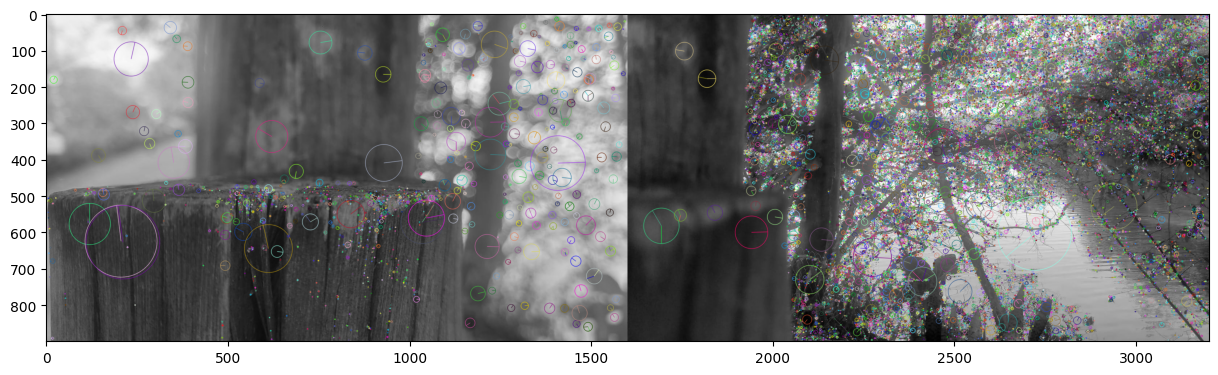

In [12]:
def SIFT(img_gray):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)
    return keypoints, descriptors

def plot_sift(img_gray, img_rgb, keypoints):
    tmp = img_rgb.copy()
    img = cv2.drawKeypoints(img_gray, keypoints, tmp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

# SIFT só usa grayscale
kp_left, des_left = SIFT(left_gray)
kp_right, des_right = SIFT(right_gray)

kp_left_img = plot_sift(left_gray, left_rgb, kp_left)
kp_right_img = plot_sift(right_gray, right_rgb, kp_right)
total_kp = np.concatenate((kp_left_img, kp_right_img), axis=1)

plt.imshow(total_kp)

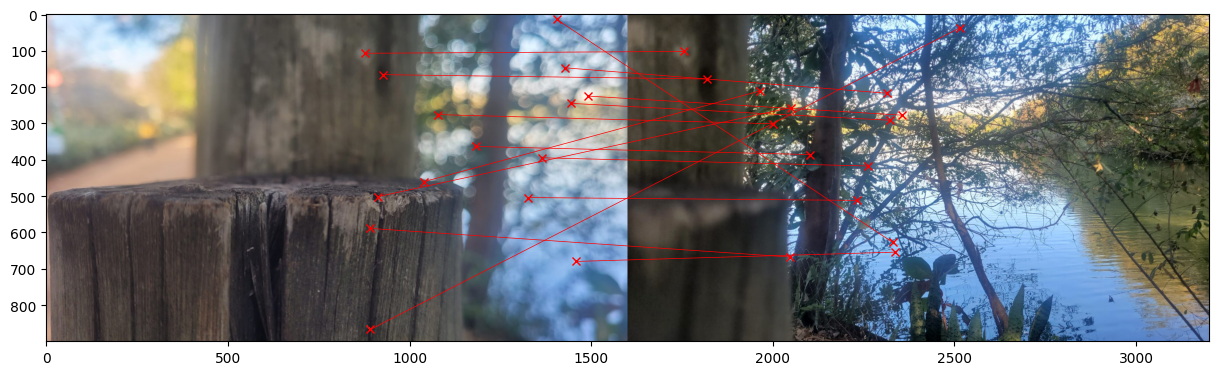

In [14]:
def matcher(kp1, des1, img1, kp2, des2, img2, threshold):
    bf = cv2.BFMatcher() # Brute Force Matcher, compara os descritores des1 e des2

    # Para cada descritor de img1, 
    # retorna os 2 matches mais próximos em img2 (com base em distância Euclidiana por padrão)
    matches = bf.knnMatch(des1,des2, k=2)

    good = []
    for m, n in matches: # m é o melhor match, n é o segundo melhor
        if m.distance < threshold * n.distance: # aplica Lowe's ratio test
            good.append([m])

    matches = []
    for pair in good:
        matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))

    matches = np.array(matches)
    return matches

def plot_matches(matches, total_img):
    match_img = total_img.copy()
    offset = total_img.shape[1]/2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8')) # RGB é do tipo inteiroi

    ax.plot(matches[:, 0], matches[:, 1], 'xr')
    ax.plot(matches[:, 2] + offset, matches[:, 3], 'xr')
        
    ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            'r', linewidth=0.5)

    plt.show()

matches = matcher(kp_left, des_left, left_rgb, kp_right, des_right, right_rgb, 0.75)

total_img = np.concatenate((left_rgb, right_rgb), axis=1)
plot_matches(matches, total_img) # Bons matches